# How a virtual hierarchy reduces memory footprint


A [virtual hierarchy](https://docs.activeviam.com/products/atoti/server/latest/docs/concepts/dimensions_and_hierarchies/#virtual-hierarchies) is a lightweight hierarchy implemented in [Atoti](https://www.atoti.io/). It offers a smaller memory footprint by not storing its members in the cube.  
This is especially handy for hierarchies with high cardinality, i.e., with many possible values. Usually, these are identifiers such as User ID, Shopping Cart ID, or Trade ID, where the hierarchy can have thousands of distinct values. These hierarchies are not the ones that one usually looks at in data analytics unless the specific use case requires a deep-dive investigation.  

Keeping a virtual hierarchy light-weight comes with some trade-offs in the features:
- Navigation between the hierarchy members are not allowed. This means that it is not possible to use [`Lead`](https://learn.microsoft.com/en-us/sql/mdx/lead-mdx?view=sql-server-ver16) and [`Lag`](https://learn.microsoft.com/en-us/sql/mdx/lag-mdx?view=sql-server-ver16) functions such as [`atoti.shift`](https://docs.atoti.io/latest/lib/atoti/atoti.function.shift.html#atoti.shift) and [`atoti.date_shift`](https://docs.atoti.io/latest/lib/atoti/atoti.function.date_shift.html) on the virtual hierarchies.  
- The virtual hierarchy cannot be a [slicing hierarchy](https://docs.atoti.io/latest/lib/atoti/atoti.hierarchy.html#atoti.Hierarchy.slicing).
- For advanced users who manipulate the underlying MDX for querying, MDX expressions that includes a virtual hierarchy must include the `NON EMPTY` keyword. Member expressions must be written with the full member path: `[Dimension].[Hierarchy].[FirstLevel].[Path].[To].[My].[Member]`.  
- In Atoti UI and the Atoti JupyterLab extension, when creating or editing a filter on a virtual hierarchy, the full list of members is not displayed. Rather, the user must type in the searchbar to find members and filter on them.  

Let's explore more of these in this notebook.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=directQuery-vector" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>

To demonstrate a case where we have a hierarchy with high cardinality, we connect to a ClickHouse instance that hosts more than 700k trade records.  
We use [Atoti DirectQuery](https://docs.atoti.io/latest/how_tos/use_directquery.html) to connect to the ClickHouse instance.  

⚠️We require a valid license to [unlock all Atoti features](https://docs.atoti.io/latest/how_tos/unlock_all_features.html) and to be able to use DirectQuery. You can register online for an [evaluation license](https://atoti.io/evaluation-license-request/).

## Setting up ClickHouse database 

To replicate the database in this use case, run the script [clickhouse_table_user.sql](./clickhouse_table_user.sql) in the use case directory in your ClickHouse instance.  
ClickHouse provides 30 days trial for its [cloud based DBMS](https://clickhouse.com/cloud).  

### Prerequisite for DirectQuery to connect to ClickHouse  

The script includes the grants required for the role of the user connecting to the ClickHouse instance using DirectQuery:  
```
CREATE ROLE querier;

GRANT SELECT ON ATOTI.* TO querier WITH GRANT OPTION;
GRANT SELECT ON system.databases TO querier WITH GRANT OPTION;
GRANT SELECT ON system.processes TO querier WITH GRANT OPTION;
GRANT SELECT ON system.tables TO querier WITH GRANT OPTION;
GRANT SELECT ON system.columns TO querier WITH GRANT OPTION;

CREATE USER IF NOT EXISTS ATOTI_QUERIER IDENTIFIED WITH sha256_password BY '<password>' DEFAULT ROLE querier;
```

### Data used

Download the [trades data](https://data.atoti.io/notebooks/direct-query/data/trades_pnl.zip) and upload it to the ClickHouse instance using the [ClickHouse Command-Line Client (CLI)](https://clickhouse.com/docs/en/install). For Windows users, first install WLS 2 by running the command `wsl --install` in PowerShell before installing [ClickHouse CLI](https://clickhouse.com/docs/en/integrations/sql-clients/clickhouse-client-local).  

The command for uploading the CSV is as follows:  

```
./clickhouse client --host "$CLICKHOUSE_HOST" --secure --password  "$CLICKHOUSE_PASSWORD" --database "$CLICKHOUSE_DB" --query="INSERT INTO TRADE_PNLS FORMAT CSV" < "$TRADE_PNL_FILE"
```

Define the variables `CLICKHOUSE_HOST`, `CLICKHOUSE_PASSWORD`, `CLICKHOUSE_DB` and `TRADE_PNL_FILE` with its corresponding values. E.g. in our use case, `CLICKHOUSE_HOST="u4si8t7f5x.asia-southeast1.gcp.clickhouse.cloud"`  

For Windows users, remember to copy the unzipped datafile to the Ubuntu directory:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/ubuntu_folder.png" width="750px"/>

Uncomment the following cell to install the [DirectQuery plugin](https://docs.atoti.io/latest/reference.html#directquery) if you haven't installed it yet.

In [1]:
# ! pip install atoti_directquery_clickhouse

In [2]:
import os

import atoti as tt
from atoti_directquery_clickhouse import (
    ClickhouseConnectionInfo,
    ClickhouseTableOptions,
)

## Get started with Atoti 

In [3]:
session = tt.Session()

We can obtain the URL for our ClickHouse connection from the cloud instance as shown below:  
<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/clickhouse_url.png" width="70%"/>  

In the below code snippet, we configure the password in a separate parameter instead of embedding it in the URL.  
This is a good practice to prevent the password from getting logged along with the URL.  
Furthermore, the ClickHouse password requires at least 1 special character, and special characters can cause problems in URLs.  

In [4]:
connection_info = ClickhouseConnectionInfo(
    f"clickhouse:https://{os.environ['CLICKHOUSE_USER']}@{os.environ['CLICKHOUSE_HOST']}:{os.environ['CLICKHOUSE_PORT']}",
    password=os.environ["CLICKHOUSE_PASSWORD"],
)

db = session.connect_to_external_database(connection_info)

Under the Atoti database, we have two tables. We are going to use only the `TRADE_PNLS` table.

In [5]:
db.tables

ExternalTables(_tables={'ATOTI': {'ATOTI': [t[('ATOTI', 'ATOTI', 'BOOKS')], t[('ATOTI', 'ATOTI', 'TRADE_PNLS')]]}, 'system': {'system': [t[('system', 'system', 'columns')], t[('system', 'system', 'databases')], t[('system', 'system', 'processes')], t[('system', 'system', 'tables')]]}}, _database_key='CLICKHOUSE', _create_table=<function ExternalDatabaseConnection.tables.<locals>.<lambda> at 0x000001B3CF10ADD0>)

In [6]:
trades_atoti = session.add_external_table(
    db.tables["TRADE_PNLS"],
    table_name="Trade PnL",
    options=ClickhouseTableOptions(keys=["AsOfDate", "TradeId", "BookId", "DataSet"]),
)

In [7]:
print(f"# of records: {len(trades_atoti)}, # of columns: {len(trades_atoti.columns)}")

# of records: 765754, # of columns: 9


### Set up Atoti cube

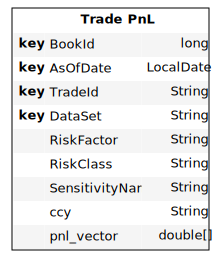

In [8]:
cube = session.create_cube(trades_atoti)
cube.schema

Before proceeding further, let's do some simple configurations that will help avoid querying the entire database.  
We set the `AsOfDate` as a slicing hierarchy and sort it in descending order.  
This way, only data from the latest `AsOfDate` will be returned by default when we query Atoti.  

In [9]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [10]:
h["AsOfDate"].slicing = True
l["AsOfDate"].order = tt.NaturalOrder(ascending=False)

Atoti is now able to retrieve data from ClickHouse without storing them in-memory.  

In [11]:
session.visualize("Daily data volume")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Cardinality Investigation

Some of our hierarchies have a high cardinality (= number of distinct values). Let's create some measures to visualize that.

In [12]:
m["Distinct Trade Id"] = tt.agg.count_distinct(trades_atoti["TradeId"])
m["Distinct BookId"] = tt.agg.count_distinct(trades_atoti["BookId"])
m["Distinct RiskFactor"] = tt.agg.count_distinct(trades_atoti["RiskFactor"])
m["Distinct RiskClass"] = tt.agg.count_distinct(trades_atoti["RiskClass"])

In [13]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

We can see that `TradeId` has far more unique values than the other hierarchies.  

Iterating through the hierarchies, we can see that only `TradeId` is set as a virtual hierarchy by the application.

In [14]:
for _hierarchy in h:
    print(f"Hierarchy name: {_hierarchy}: {h[_hierarchy].virtual}")

Hierarchy name: ('Trade PnL', 'RiskFactor'): False
Hierarchy name: ('Trade PnL', 'AsOfDate'): False
Hierarchy name: ('Trade PnL', 'ccy'): False
Hierarchy name: ('Trade PnL', 'BookId'): False
Hierarchy name: ('Trade PnL', 'RiskClass'): False
Hierarchy name: ('Trade PnL', 'DataSet'): False
Hierarchy name: ('Trade PnL', 'SensitivityName'): False
Hierarchy name: ('Trade PnL', 'TradeId'): True


⚠️It is important to know that **with the use of DirectQuery, a hierarchy is automatically set as virtual if its cardinality is greater than or equal to 10000**.  
Without DirectQuery, we have to explicitly set a hierarchy as virtual where necessary.

### Trade-off on interactive filtering

Normally, when creating or editing filters on a visualization using Atoti UI or the Atoti JupyterLab extension, the popover displays the full list of members of the selected hierarchy:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/normal_hierarchy_filter.gif" width="75%"/>  

For virtual hierarchies, while the members are not retrieved by default, we can search on demand:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/filter-on-demand.gif" width="75%" />  

In [15]:
session.visualize("Virtual Hierarchy")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### MDX with Non Empty for a virtual hierarchy 

In [Multidimensional Expressions (MDX)](https://learn.microsoft.com/en-us/analysis-services/multidimensional-models/mdx/mdx-query-the-basic-query?view=asallproducts-allversions), the keyword [`Non Empty`](https://learn.microsoft.com/en-us/sql/mdx/nonempty-mdx?view=sql-server-ver16) is used to filter out empty cells from the result set of a query.

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/mdx.png"/>  

_We can inspect the generated MDX of a visualization by expanding on the Property Inspector of JupyterLab for its cell._    


MDX expressions including a virtual hierarchy must include the `NON EMPTY` keyword. Let's see what happens when we remove it for the rows containing our `TradeId` from the MDX above: 

In [16]:
session.visualize("Virtual Hierarchy - not working as expected")

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

### Memory footprint difference between virtual and non-virtual hierarchies

From the [server log](https://docs.atoti.io/latest/lib/atoti/atoti.config.logging_config.html#atoti.LoggingConfig) (found under `$HOME/.atoti` folder by default), we can see that we have only utilized 140KB of direct memory and less than 100 MB of heap so far:  

<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/virtual_hierarchy_mem_usage.png" />  

Let's try changing the `TradeId` into a non-virtual hierarchy.

In [17]:
h["TradeId"].virtual = False

After setting the `virtual` parameter to `False` for the `TradeId` hierarchy, the memory usage increases.  
Now, we utilize more than 1 MB of direct memory. 
  
<img src="https://data.atoti.io/notebooks/virtual-hierarchies/img/non-virtual_hierarchy_mem_usage.png" />

We see that setting a hierarchy as virtual makes it lightweight memory-wise, while still being queryable by users, just in a slightly more restrictive way.  
The trade-off between a smaller memory footprint and faster commit times versus offering a slightly reduced set of features is definitely worth it.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=directQuery-vector" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>